In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install datasets
!pip install transformers
!pip install torch

# Getting Dataset from gpt-2 github train data. (Don't run from here unless new)


In [ ]:
import os
import sys
import requests
from tqdm import tqdm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set directory path to Google Drive
subdir = '/content/drive/MyDrive/data'
if not os.path.exists(subdir):
    os.makedirs(subdir)
subdir = subdir.replace('\\','/') # needed for Windows

for ds in [
    'webtext',
    'small-117M',  'small-117M-k40',
    'medium-345M', 'medium-345M-k40',
    'large-762M',  'large-762M-k40',
    'xl-1542M',    'xl-1542M-k40',
]:
    for split in ['train', 'valid', 'test']:
        filename = ds + "." + split + '.jsonl'
        r = requests.get("https://openaipublic.azureedge.net/gpt-2/output-dataset/v1/" + filename, stream=True)

        with open(os.path.join(subdir, filename), 'wb') as f:
            file_size = int(r.headers["content-length"])
            chunk_size = 1000
            with tqdm(ncols=100, desc="Fetching " + filename, total=file_size, unit_scale=True) as pbar:
                # 1k for chunk_size, since Ethernet packet size is around 1500 bytes
                for chunk in r.iter_content(chunk_size=chunk_size):
                    f.write(chunk)
                    pbar.update(chunk_size)


In [ ]:
import json

with open('/content/drive/MyDrive/data/webtext.train.jsonl', 'r') as f:
    for i in range(1000):
        line = f.readline()
        data = json.loads(line)
        print(data)
        print('--------------------------------------')

add the labels for the text to show human data

In [ ]:
import json

human_data = {}

with open('/content/drive/MyDrive/data/webtext.train.jsonl', 'r') as f:
    for i in range(1000):
        line = f.readline()
        data = json.loads(line)


        human_data[i] = {'text': data['text'], 'is_human': True}[0]

print('Number of human-written texts:', len(human_data))

for i in range(2):
  print(human_data[i])
  #print(is_human)

Number of human-written texts: 100
{'text': "These girlfriends deserves a special mention for going that extra mile, hopefully doesn't set too many guys off on the path towards outrageous demands.\n\n1. She knows the severity of man-flu\n\n2. All fun and games is all good\n\n3. A voucher that says 'I love you'\n\n4. When arguments don't drag on forever.\n\n5. Providing everything he needs.\n\n6. Very understanding\n\n7. As awesome a gesture as this is, we are worried about this man's cooking skills.\n\n8. Nice cake\n\n8. Fair bargaining\n\n9. Excellent gift choice\n\n10. Very thoughtful", 'is_human': True}
{'text': 'LeSean McCoy going through warmups with first team offense. To my eye, does not look close to 100 percent when cutting and exploding.\n\nABOUT COOKIES\n\nTo help make this website better, to improve and personalize your experience and for advertising purposes, are you happy to accept cookies and other technologies?', 'is_human': True}


# Getting the data from drive and creating human data file

In [ ]:
import json
import random

human_data = {}

# open the webtext.train.jsonl file and read all the lines
with open('/content/drive/MyDrive/data/webtext.train.jsonl', 'r') as f:
    lines = f.readlines()

# randomly select texts from the lines list
selected_lines = random.sample(lines, k=2000)

# save the selected texts and their is_human flag to the human_data dictionary
for i, line in enumerate(selected_lines):
    data = json.loads(line)
    human_data[i] = {'text': data['text'], 'is_human': True}

# print the number of selected texts and the first text
print('Number of selected texts:', len(human_data))

# save generated text to a JSON file in the mounted Google Drive folder
with open('/content/drive/My Drive/generated data/human_text4_2k.json', 'w') as f:
    json.dump(human_data, f)

for i in range(2):
  print(len(human_data[i]['text'].split()))
  print(human_data[i]['text'])
  print("-----------------------------------------------")


# Generating data from human data prompts

In [ ]:
import json
import random
from transformers import GPT2LMHeadModel, GPT2Tokenizer

def get_random_prompt(text):
    words = text.split()
    prompt_length = random.randint(10, 15)
    prompt_start = random.randint(0, len(words) - prompt_length)
    prompt_end = prompt_start + prompt_length
    prompt = ' '.join(words[prompt_start:prompt_end])
    return prompt

def generate_text(prompt, model, tokenizer, max_length):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    attention_mask = inputs["attention_mask"]
    outputs = model.generate(input_ids=inputs["input_ids"], attention_mask=attention_mask, max_length=max_length, num_return_sequences=1, do_sample=True, temperature=0.8, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_text

def generate_text_and_save_to_file(filename, num_texts_to_generate=500):
    model_name = "gpt2"
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = GPT2LMHeadModel.from_pretrained(model_name)

    with open('/content/drive/My Drive/generated data/human_text4_2k.json', 'r') as f:
        human_data = json.load(f)

    generated_text = {}
    for i in range(num_texts_to_generate):
        selected_dict = random.choice(list(human_data.keys()))
        selected_text = human_data[selected_dict]['text']

        prompt = get_random_prompt(selected_text)
        max_length = len(selected_text.split())
        if max_length > 700:
            max_length = 700

        data = generate_text(prompt, model, tokenizer, max_length)

        print(f"Generated text {i+1}/{num_texts_to_generate}")
        print(f"Prompt: {prompt}")
        print(f"Generated text: {data}")
        print(f"Max length: {max_length}")
        print("---------------------------------------------------------------------")

        generated_text[i] = {'text': data, 'is_human': False}

    with open(f'/content/drive/My Drive/generated data/{filename}', 'w') as d:
        json.dump(generated_text, d)

    print(f"Text generation complete. {filename} has been saved.")






In [ ]:
generate_text_and_save_to_file('generated_text.json', 500)

In [ ]:
generate_text_and_save_to_file('generated_text2.json', 500)

In [ ]:
generate_text_and_save_to_file('generated_text3.json', 500)

In [ ]:
generate_text_and_save_to_file('generated_text4.json', 500)

# Putting the data together into one dataset (run from here to not overwrite any existing files)

In [ ]:

import json
import numpy as np

def get_data_json(filename):
  with open(f'/content/drive/My Drive/generated data/{filename}.json', 'r') as f:
    text = json.load(f)

  return text
# Open the human_text4_2k.jsonl file and read all the lines
human_text = get_data_json("human_text4_2k")

# Open the generated text file and read all the lines

generated_text = get_data_json("generated_text")
print("gen1", len(generated_text))

# Open the generated text 2 file and read all the lines
generated_text2 = get_data_json("generated_text2")
print("gen2", len(generated_text2))

# Open the generated text 3 file and read all the lines
generated_text3 = get_data_json("generated_text3")
print("gen3", len(generated_text3))

# Open the generated text 4 file and read all the lines
generated_text4 = get_data_json("generated_text4")
print("gen4", len(generated_text4))

def merge(list1, list2):
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

def text_label_conv(dictionary):
  text = []
  label = []

  for key in dictionary.keys():
    text.append(dictionary[key]['text'])
    label.append(dictionary[key]['is_human'])

  return text,label

gen_text, gen_label = text_label_conv(generated_text)
gen_text2, gen_label2 = text_label_conv(generated_text2)
gen_text3, gen_label3 = text_label_conv(generated_text3)
gen_text4, gen_label4 = text_label_conv(generated_text4)

hum_text, hum_label = text_label_conv(human_text)

gen_data = merge(gen_text, gen_label)
gen_data2 = merge(gen_text2, gen_label2)
gen_data3 = merge(gen_text3, gen_label3)
gen_data4 = merge(gen_text4, gen_label4)
hum_data = merge(hum_text, hum_label)

print(hum_data[0])
print(gen_data4[0])

# Concatenate the two datasets
combined_data = np.concatenate((hum_data, gen_data, gen_data2, gen_data3, gen_data4))

print(len(combined_data))

# Pre processing functions

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


def no_change(text):
    return text.lower()

def preprocess_tokenization(text):
    return word_tokenize(text.lower())

def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word not in stop_words]

def lemmatize(text):
    tokens = word_tokenize(text.lower())
    tokens_no_stopwords = [word for word in tokens if word not in stop_words]
    return [lemmatizer.lemmatize(token) for token in tokens_no_stopwords]

def stem(text):
    tokens = word_tokenize(text.lower())
    tokens_no_stopwords = [word for word in tokens if word not in stop_words]
    return [stemmer.stem(token) for token in tokens_no_stopwords]

def pos_tagging(text):
    tokens = word_tokenize(text.lower())
    return [f"{token}_{tag}" for token, tag in pos_tag(tokens)]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# SVM and RF

cross validate


In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold

# Pre-process data
def preprocess_data(data, preprocess_func):
    data_preprocessed = data.copy()
    if preprocess_func == no_change:
        data_preprocessed[:, 0] = np.array([text.lower() for text in data_preprocessed[:, 0]])
    else:
        preprocessed_texts = [preprocess_func(text) for text in data_preprocessed[:, 0]]
        data_preprocessed[:, 0] = np.array([' '.join(text) for text in preprocessed_texts], dtype=object)
    return data_preprocessed

def train_and_evaluate(X, y, tfidf_ngram_range, cv=5):
    # SVM pipeline
    svm_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=tfidf_ngram_range)),
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', SVC())
    ])

    # Random Forest pipeline
    rf_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=tfidf_ngram_range)),
        ('classifier', RandomForestClassifier())
    ])

    # Train and evaluate the classifiers using cross-validation
    pipelines = [svm_pipeline, rf_pipeline]
    metrics = []

    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

    for pipe in pipelines:
        cv_results = cross_validate(pipe, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=2))
        accuracy_mean = np.mean(cv_results['test_accuracy'])
        precision_mean = np.mean(cv_results['test_precision_weighted'])
        recall_mean = np.mean(cv_results['test_recall_weighted'])
        f1_mean = np.mean(cv_results['test_f1_weighted'])

        metrics.append((accuracy_mean, precision_mean, recall_mean, f1_mean))

    return metrics


data_np = combined_data

preprocessing_functions = [
    ('Raw Text', no_change),
    ('Tokenization', preprocess_tokenization),
    ('Stop Word Removal', remove_stopwords),
    ('Lemmatization', lemmatize),
    ('Stemming', stem),
    ('POS Tagging', pos_tagging)
]

metrics_svm = []
metrics_rf = []

ngrams = [1, 2, 3]

for preprocess_name, preprocess_func in preprocessing_functions:
    data_preprocessed = preprocess_data(data_np, preprocess_func)

    for ngram in ngrams:
        # Skip n-gram values greater than 1 for raw text preprocessing
        if preprocess_name == "Raw Text" and ngram > 1:
            continue

        X = data_preprocessed[:, 0]
        y = data_preprocessed[:, 1]

        metrics = train_and_evaluate(X, y, (ngram, ngram))
        svm_metrics, rf_metrics = metrics[0], metrics[1]

        metrics_svm.append((preprocess_name, ngram, svm_metrics[0], svm_metrics[1], svm_metrics[2], svm_metrics[3]))
        metrics_rf.append((preprocess_name, ngram, rf_metrics[0], rf_metrics[1], rf_metrics[2], rf_metrics[3]))

        print(f"Preprocessing: {preprocess_name}, N-gram: {ngram}")
        print("SVM Metrics (Mean):")
        print(f"Accuracy: {svm_metrics[0]}, Precision: {svm_metrics[1]}, Recall: {svm_metrics[2]}, F1-score: {svm_metrics[3]}")
        print("Random Forest Metrics (Mean):")
        print(f"Accuracy: {rf_metrics[0]}, Precision: {rf_metrics[1]}, Recall: {rf_metrics[2]}, F1-score: {rf_metrics[3]}")
        print("\n")



Preprocessing: Raw Text, N-gram: 1
SVM Metrics (Mean):
Accuracy: 0.6824999999999999, Precision: 0.7423693271719654, Recall: 0.6824999999999999, F1-score: 0.6615520339557877
Random Forest Metrics (Mean):
Accuracy: 0.748, Precision: 0.7644891027715583, Recall: 0.748, F1-score: 0.7439389063522449


Preprocessing: Tokenization, N-gram: 1
SVM Metrics (Mean):
Accuracy: 0.682, Precision: 0.7417238936313677, Recall: 0.682, F1-score: 0.6610106809132924
Random Forest Metrics (Mean):
Accuracy: 0.76, Precision: 0.7765413138966186, Recall: 0.76, F1-score: 0.7564145412018842


Preprocessing: Tokenization, N-gram: 2
SVM Metrics (Mean):
Accuracy: 0.67125, Precision: 0.7100536601724068, Recall: 0.67125, F1-score: 0.655288308161751
Random Forest Metrics (Mean):
Accuracy: 0.602, Precision: 0.7044657670888785, Recall: 0.602, F1-score: 0.5445145323233446


Preprocessing: Tokenization, N-gram: 3
SVM Metrics (Mean):
Accuracy: 0.6155, Precision: 0.6211199963780846, Recall: 0.6155, F1-score: 0.611114430377737


# RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score



# RNN with stratified k fold

In [ ]:
from sklearn.model_selection import StratifiedKFold

def train_and_evaluate_rnn(X, y, preprocess_name, preprocess_func, ngram, cv=5):
    # Initialize the metrics
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    confusion_matrices = []

    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=2)

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(X_train)
        X_train_seq = tokenizer.texts_to_sequences(X_train)
        X_test_seq = tokenizer.texts_to_sequences(X_test)

        max_length = max([len(seq) for seq in X_train_seq])

        X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
        X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

        # RNN model
        model = Sequential()
        model.add(Embedding(len(tokenizer.word_index) + 1, 64, input_length=max_length))
        model.add(SimpleRNN(32))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train_pad, y_train, batch_size=32, epochs=5, verbose=0)

        # Evaluate
        y_pred = (model.predict(X_test_pad) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        c_matrix = confusion_matrix(y_test, y_pred)

        # Append the metrics for this fold
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        confusion_matrices.append(c_matrix)

    # Calculate the mean of the metrics
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_f1 = np.mean(f1_scores)

    return mean_accuracy, mean_precision, mean_recall, mean_f1, confusion_matrices, ngram


metrics_rnn = []


data_np = combined_data

for preprocess_name, preprocess_func in preprocessing_functions:
    data_preprocessed = preprocess_data(data_np, preprocess_func)
    ngram = 1
    X = data_preprocessed[:, 0]
    y = np.array([1 if value == 'True' else 0 for value in data_preprocessed[:, 1]])

    metrics = train_and_evaluate_rnn(X, y, preprocess_name, preprocess_func, ngram)
    mean_accuracy, mean_precision, mean_recall, mean_f1, confusion_matrices, ngram = metrics

    metrics_rnn.append((preprocess_name, ngram, mean_accuracy, mean_precision, mean_recall, mean_f1))

    print(f"RNN Preprocessing: {preprocess_name}")
    print(f"Mean Accuracy: {mean_accuracy}, Mean Precision: {mean_precision}, Mean Recall: {mean_recall}, Mean F1-score: {mean_f1}")
    print("Confusion Matrices:")
    for i, c_matrix in enumerate(confusion_matrices):
        print(f"Fold {i + 1}:")
        print(c_matrix)
    print("\n")


In [ ]:
print(metrics_rnn)
#print(metrics_rf)
#print(metrics_svm)

[('Raw Text', 1, 0.5094999999999998, 0.5514331536947237, 0.5094999999999998, 0.4206394798959824), ('Tokenization', 1, 0.4950000000000001, 0.44373940053742145, 0.4950000000000001, 0.4532313809249944), ('Stop Word Removal', 1, 0.5085000000000001, 0.4600309859621853, 0.5085000000000001, 0.469450706825486), ('Lemmatization', 1, 0.49625, 0.39601280456128995, 0.49625, 0.4158137547136775), ('Stemming', 1, 0.5115000000000001, 0.41157405438331207, 0.5115000000000001, 0.44456882331621195), ('POS Tagging', 1, 0.501, 0.40103793852135655, 0.501, 0.43294994564671646)]


# Plotting the results

# Metrics

In [ ]:
print(metrics_svm)
print(metrics_rf)
print(metrics_rnn)



[('Raw Text', 1, 0.6824999999999999, 0.7423693271719654, 0.6824999999999999, 0.6615520339557877), ('Tokenization', 1, 0.682, 0.7417238936313677, 0.682, 0.6610106809132924), ('Tokenization', 2, 0.67125, 0.7100536601724068, 0.67125, 0.655288308161751), ('Tokenization', 3, 0.6155, 0.6211199963780846, 0.6155, 0.611114430377737), ('Stop Word Removal', 1, 0.6677500000000001, 0.7278658244320203, 0.6677500000000001, 0.644287425833798), ('Stop Word Removal', 2, 0.5662499999999999, 0.5947671845050767, 0.5662499999999999, 0.5316294761517518), ('Stop Word Removal', 3, 0.522, 0.5222591075684765, 0.522, 0.5203107702438191), ('Lemmatization', 1, 0.6677500000000001, 0.7135925726028439, 0.6677500000000001, 0.6489195252640778), ('Lemmatization', 2, 0.5695, 0.6055994221869331, 0.5695, 0.5296060220423542), ('Lemmatization', 3, 0.519, 0.5190764499731173, 0.519, 0.5180538263390317), ('Stemming', 1, 0.67625, 0.7055911413477012, 0.67625, 0.6643099982284681), ('Stemming', 2, 0.5650000000000001, 0.6207159796727

# Saving data

In [ ]:
#metrics_svm = [('Raw Text', 1, 0.69, 0.7275523095144097, 0.69, 0.6701529175865352), ('Tokenization', 1, 0.69, 0.7275523095144097, 0.69, 0.6701529175865352), ('Tokenization', 2, 0.6175, 0.6200178393627614, 0.6175, 0.6082930542894271), ('Tokenization', 3, 0.50375, 0.5229955277280858, 0.50375, 0.47645439340365914), ('Stop Word Removal', 1, 0.68625, 0.7245666284603692, 0.68625, 0.6654891577392884), ('Stop Word Removal', 2, 0.48875, 0.4972569521578448, 0.48875, 0.4798908379755838), ('Stop Word Removal', 3, 0.4775, 0.4956841777408638, 0.4775, 0.4018112795216111), ('Lemmatization', 1, 0.6675, 0.6938581703932889, 0.6675, 0.6484928678678679), ('Lemmatization', 2, 0.4875, 0.493126539408867, 0.4875, 0.48459958385299473), ('Lemmatization', 3, 0.4675, 0.4748828125, 0.4675, 0.39972727272727276), ('Stemming', 1, 0.6925, 0.7071472886029412, 0.6925, 0.6823317397182436), ('Stemming', 2, 0.47875, 0.48032820517628233, 0.47875, 0.47914365211028226), ('Stemming', 3, 0.46625, 0.4735968192489426, 0.46625, 0.41337240065701436), ('POS Tagging', 1, 0.70875, 0.73689139944478, 0.70875, 0.6948545834017694), ('POS Tagging', 2, 0.64125, 0.6414062822994382, 0.64125, 0.6413191288368355), ('POS Tagging', 3, 0.5025, 0.5306798487324693, 0.5025, 0.4571255814578795)]
#metrics_rf = [('Raw Text', 1, 0.76625, 0.7924883007401843, 0.76625, 0.7633809243450104), ('Tokenization', 1, 0.765, 0.7897950819672132, 0.765, 0.7623159504376664), ('Tokenization', 2, 0.7475, 0.7987557110020148, 0.7475, 0.7400202380040348), ('Tokenization', 3, 0.71, 0.7767283875667799, 0.71, 0.696997239301485), ('Stop Word Removal', 1, 0.7675, 0.7830115968801314, 0.7675, 0.766184201455261), ('Stop Word Removal', 2, 0.75125, 0.7884868846874469, 0.75125, 0.7462300922941438), ('Stop Word Removal', 3, 0.735, 0.7803868813825607, 0.735, 0.7278506131549611), ('Lemmatization', 1, 0.75625, 0.7697666896670691, 0.75625, 0.7551061176172155), ('Lemmatization', 2, 0.7475, 0.7837795570188567, 0.7475, 0.7424974664943882), ('Lemmatization', 3, 0.74375, 0.784767741646016, 0.74375, 0.7377913032570709), ('Stemming', 1, 0.765, 0.7811080414278738, 0.765, 0.7635739361568744), ('Stemming', 2, 0.75375, 0.7828492033901691, 0.75375, 0.7501316177525861), ('Stemming', 3, 0.7575, 0.78739, 0.7575, 0.7538597227392905), ('POS Tagging', 1, 0.745, 0.7738733333333333, 0.745, 0.741172079581522), ('POS Tagging', 2, 0.7175, 0.782716822935449, 0.7175, 0.705462315838383), ('POS Tagging', 3, 0.66, 0.7513579474342928, 0.66, 0.6349687034277198)]
#metrics_rnn = [('Raw Text', 1, 0.5125, 0.5228885135135135, 0.5125, 0.5045463589335455), ('Tokenization', 1, 0.50125, 0.5010435294117648, 0.50125, 0.5011397385663956), ('Stop Word Removal', 1, 0.5275, 0.27825625, 0.5275, 0.36432896890343697), ('Lemmatization', 1, 0.4725, 0.22325625, 0.4725, 0.30323429541595925), ('Stemming', 1, 0.50875, 0.47725539568345327, 0.50875, 0.42995037172550693), ('POS Tagging', 1, 0.4775, 0.48880362667857485, 0.4775, 0.4484290430334821)]
metrics_svm =[('Raw Text', 1, 0.6824999999999999, 0.7423693271719654, 0.6824999999999999, 0.6615520339557877), ('Tokenization', 1, 0.682, 0.7417238936313677, 0.682, 0.6610106809132924), ('Tokenization', 2, 0.67125, 0.7100536601724068, 0.67125, 0.655288308161751), ('Tokenization', 3, 0.6155, 0.6211199963780846, 0.6155, 0.611114430377737), ('Stop Word Removal', 1, 0.6677500000000001, 0.7278658244320203, 0.6677500000000001, 0.644287425833798), ('Stop Word Removal', 2, 0.5662499999999999, 0.5947671845050767, 0.5662499999999999, 0.5316294761517518), ('Stop Word Removal', 3, 0.522, 0.5222591075684765, 0.522, 0.5203107702438191), ('Lemmatization', 1, 0.6677500000000001, 0.7135925726028439, 0.6677500000000001, 0.6489195252640778), ('Lemmatization', 2, 0.5695, 0.6055994221869331, 0.5695, 0.5296060220423542), ('Lemmatization', 3, 0.519, 0.5190764499731173, 0.519, 0.5180538263390317), ('Stemming', 1, 0.67625, 0.7055911413477012, 0.67625, 0.6643099982284681), ('Stemming', 2, 0.5650000000000001, 0.6207159796727826, 0.5650000000000001, 0.5082655426728033), ('Stemming', 3, 0.5257499999999999, 0.52578744210787, 0.5257499999999999, 0.5255017449283061), ('POS Tagging', 1, 0.6882499999999999, 0.7344991574079156, 0.6882499999999999, 0.6720031701959323), ('POS Tagging', 2, 0.68675, 0.692372907026911, 0.68675, 0.6844137763574719), ('POS Tagging', 3, 0.6134999999999999, 0.6138954162758452, 0.6134999999999999, 0.6132169560034326)]
metrics_rf = [('Raw Text', 1, 0.748, 0.7644891027715583, 0.748, 0.7439389063522449), ('Tokenization', 1, 0.76, 0.7765413138966186, 0.76, 0.7564145412018842), ('Tokenization', 2, 0.602, 0.7044657670888785, 0.602, 0.5445145323233446), ('Tokenization', 3, 0.5279999999999999, 0.5280692457613145, 0.5279999999999999, 0.5271541232835563), ('Stop Word Removal', 1, 0.766, 0.774486550205845, 0.766, 0.7641741694177006), ('Stop Word Removal', 2, 0.5695, 0.6695457516644183, 0.5695, 0.4948277953022561), ('Stop Word Removal', 3, 0.518, 0.6094676864209769, 0.518, 0.39140098737222767), ('Lemmatization', 1, 0.76675, 0.7764803648105796, 0.76675, 0.7646618407071164), ('Lemmatization', 2, 0.5635000000000001, 0.6681946513494847, 0.5635000000000001, 0.4823478717627488), ('Lemmatization', 3, 0.528, 0.622749582972376, 0.528, 0.41617277795243296), ('Stemming', 1, 0.7649999999999999, 0.772661452053671, 0.7649999999999999, 0.763349515210155), ('Stemming', 2, 0.57375, 0.6782062022282525, 0.57375, 0.5004010529208915), ('Stemming', 3, 0.52425, 0.6333583532856069, 0.52425, 0.4017404662700533), ('POS Tagging', 1, 0.7405, 0.7577653655339271, 0.7405, 0.7360577474506869), ('POS Tagging', 2, 0.5747500000000001, 0.6818714844299278, 0.5747500000000001, 0.5011780780929624), ('POS Tagging', 3, 0.5207499999999999, 0.5210421894437035, 0.5207499999999999, 0.5189854688108857)]
metrics_rnn =[('Raw Text', 1, 0.5094999999999998, 0.5514331536947237, 0.5094999999999998, 0.4206394798959824), ('Tokenization', 1, 0.4950000000000001, 0.44373940053742145, 0.4950000000000001, 0.4532313809249944), ('Stop Word Removal', 1, 0.5085000000000001, 0.4600309859621853, 0.5085000000000001, 0.469450706825486), ('Lemmatization', 1, 0.49625, 0.39601280456128995, 0.49625, 0.4158137547136775), ('Stemming', 1, 0.5115000000000001, 0.41157405438331207, 0.5115000000000001, 0.44456882331621195), ('POS Tagging', 1, 0.501, 0.40103793852135655, 0.501, 0.43294994564671646)]



# Printing graphs

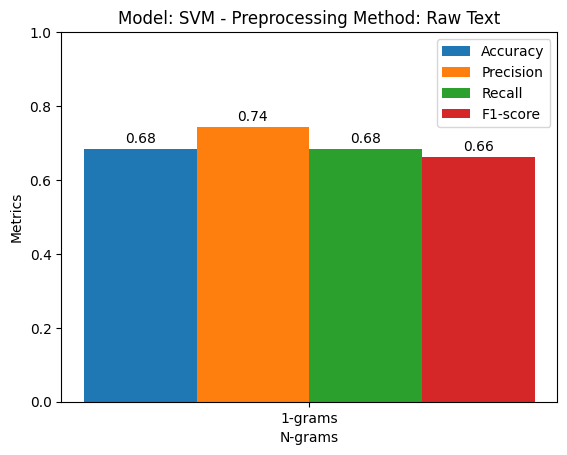

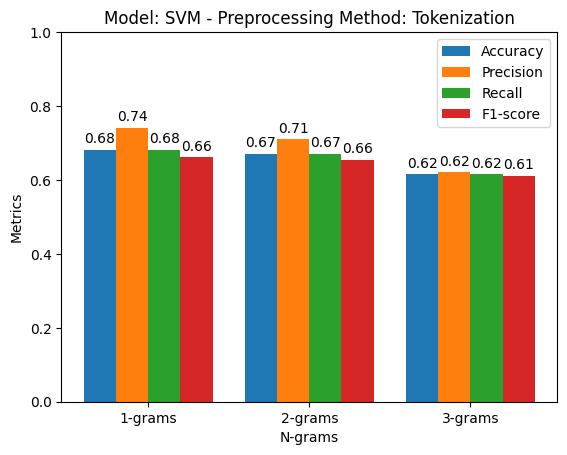

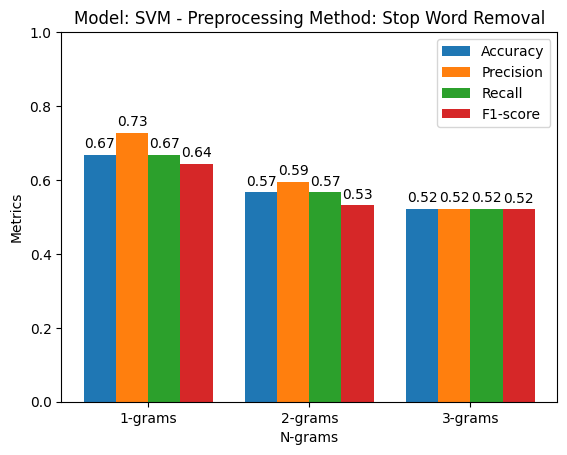

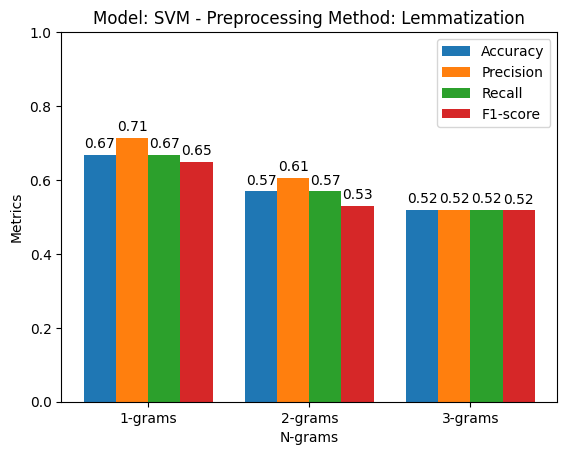

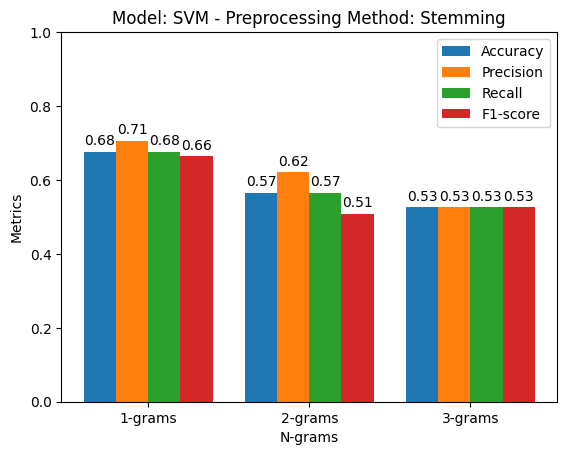

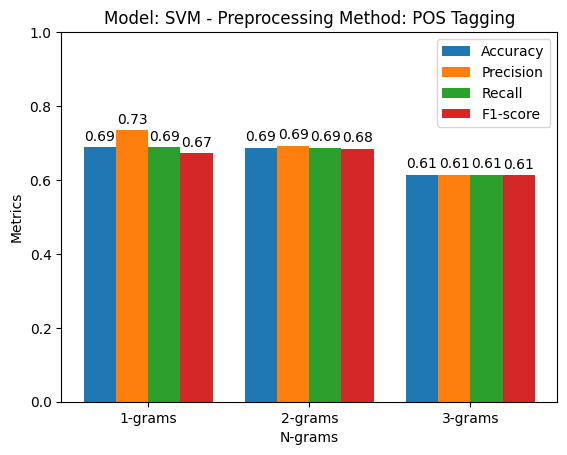

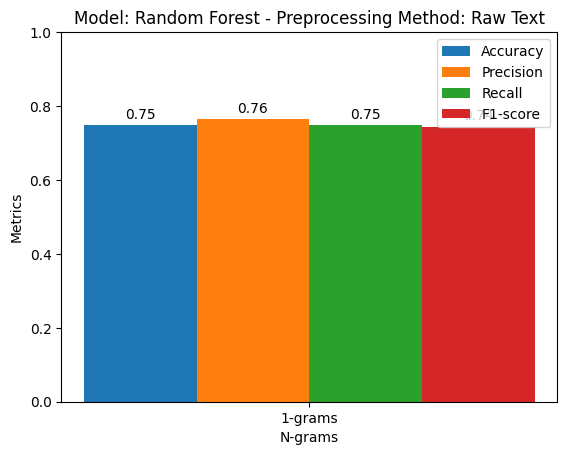

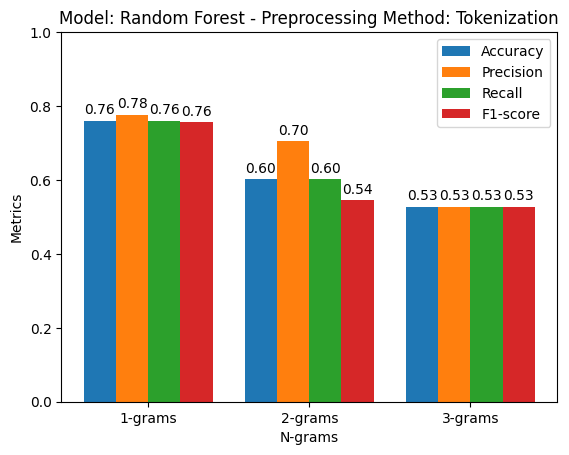

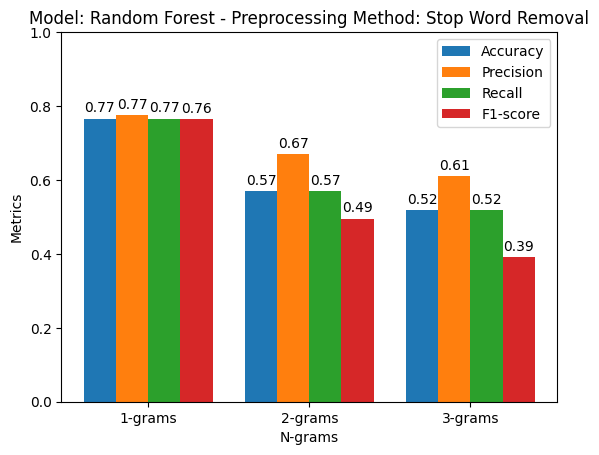

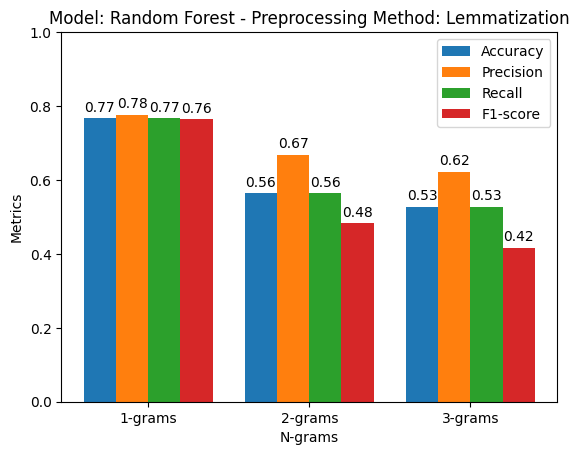

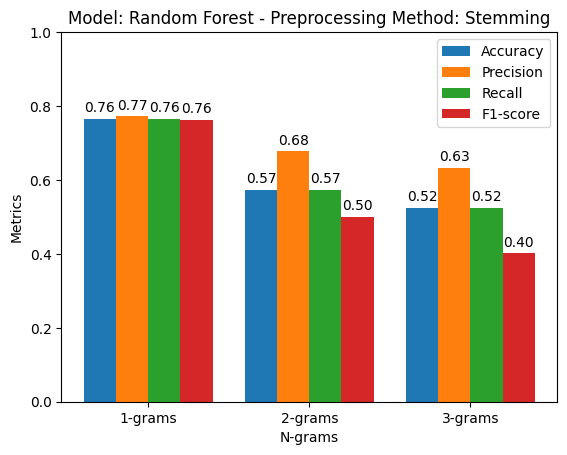

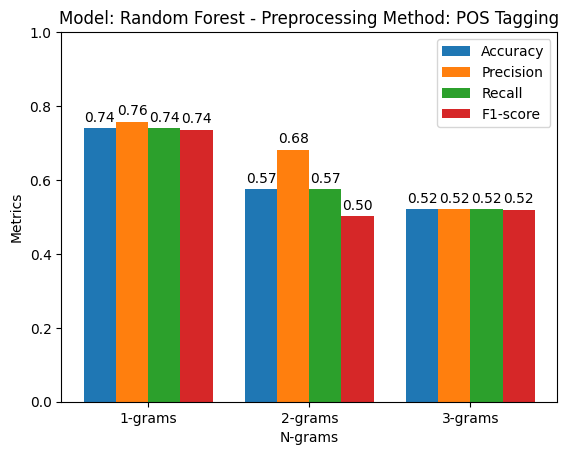

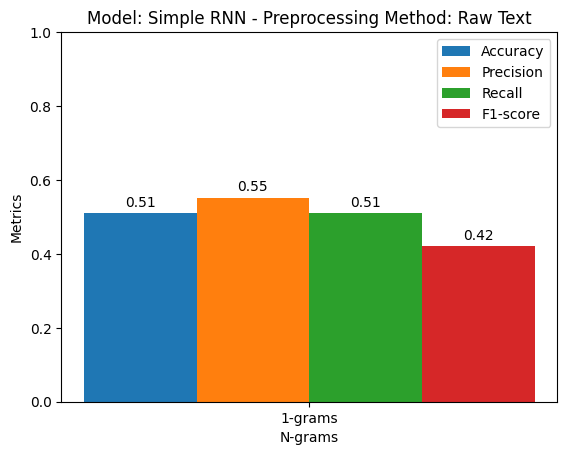

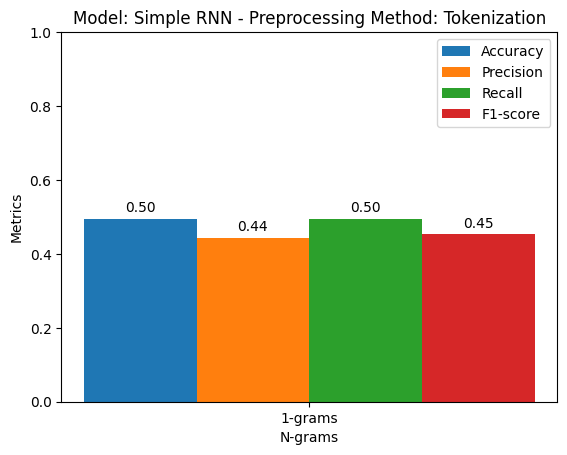

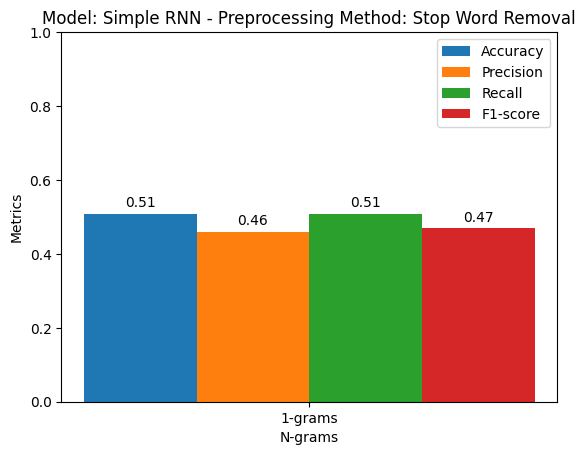

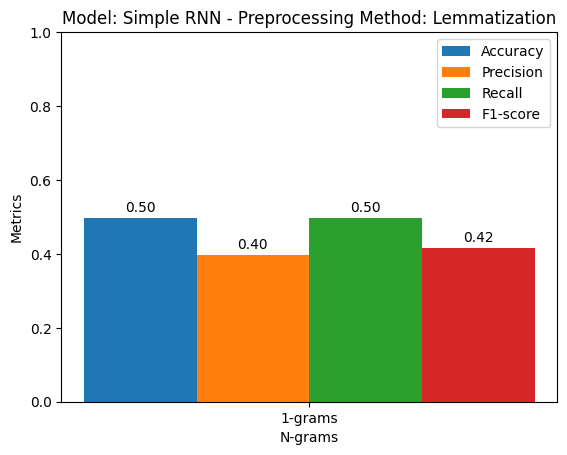

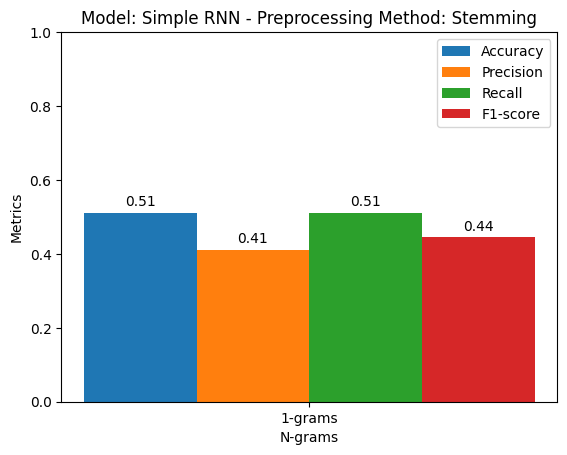

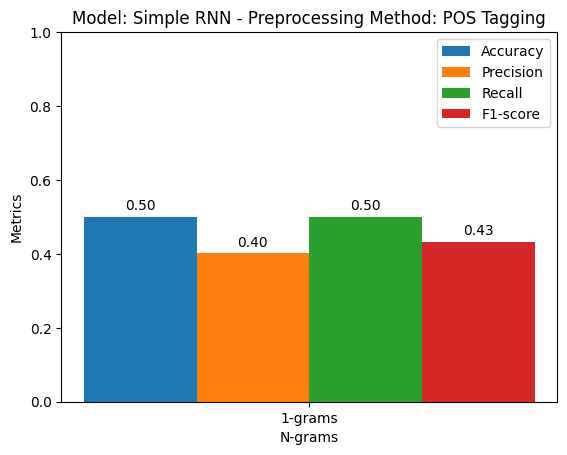

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

output_folder = "/content/drive/MyDrive/graphs1"

data = [

    ('SVM', metrics_svm),
    ('Random Forest', metrics_rf),
    ('Simple RNN', metrics_rnn)

]


for model_name, model_data in data:


    # Group data by preprocessing method
    grouped_data = {}
    for method, n_gram, accuracy, precision, recall, f1_score in model_data:
        if method not in grouped_data:
            grouped_data[method] = []
        grouped_data[method].append((n_gram, accuracy, precision, recall, f1_score))

    # Set up the bar width
    bar_width = 0.2

    # Create a separate graph for each preprocessing method
    for method, method_data in grouped_data.items():
        # Extract the data into separate lists
        n_grams, accuracy, precision, recall, f1_score = zip(*method_data)

        # Set up the x-axis
        x = np.arange(len(n_grams))

        # Plot the bar chart
        fig, ax = plt.subplots()
        ax.bar(x - bar_width*1.5, accuracy, width=bar_width, label='Accuracy')
        ax.bar(x - bar_width*0.5, precision, width=bar_width, label='Precision')
        ax.bar(x + bar_width*0.5, recall, width=bar_width, label='Recall')
        ax.bar(x + bar_width*1.5, f1_score, width=bar_width, label='F1-score')

        # Set x-axis labels
        ax.set_xticks(x)
        ax.set_xticklabels([f"{n}-grams" for n in n_grams])

        # Add legend and labels
        ax.legend()
        chart_title = f"Model: {model_name} - Preprocessing Method: {method}"
        ax.set_title(f"Model: {model_name} - Preprocessing Method: {method}")
        ax.set_xlabel('N-grams')
        ax.set_ylabel('Metrics')
        ax.set_ylim(0, 1)
         # Add actual values above bars
        for i, (a, p, r, f) in enumerate(zip(accuracy, precision, recall, f1_score)):
            ax.text(i - bar_width*1.5, a + 0.01, f"{a:.2f}", ha='center', va='bottom')
            ax.text(i - bar_width*0.5, p + 0.01, f"{p:.2f}", ha='center', va='bottom')
            ax.text(i + bar_width*0.5, r + 0.01, f"{r:.2f}", ha='center', va='bottom')
            ax.text(i + bar_width*1.5, f + 0.01, f"{f:.2f}", ha='center', va='bottom')

        file_name = chart_title.replace(':', '').replace(' ', '_') + '.png'
        output_path = f"{output_folder}/{file_name}"
        plt.savefig(output_path, bbox_inches='tight')

# Show the chart
plt.show()